#### **Universidade Federal da Bahia.**
#### **Departamento de Eng. Elétrica e Computação**
#### **Avaliação 3 - Introdução ao Aprendizado de Máquina**
#### Semestre: 2023.2
#### Alunos : Ricardo Machado e Rodrigo Pimentel

Resumo: Este trabalho apresenta a implementação de uma rede MLP(Multi-layer Perceptron) de duas camadas, utilizando como base um [banco de dados de grãos de arroz](https://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmancik). O problema solucionado com a implementação da rede foi a classificação dos grãos, que podem ser Cammeo ou Osmancik. Foram utilizados alguns metodos para a avaliar o funcionamento do modelo, como o método de validação cruzada k-fold.

### Questão 1: Escolha uma tarefa de classificação ou regressão que possa ser abordada utilizando Perceptrons Multicamadas (MLPs). Selecione um conjunto de dados apropriado (sugestões em https://archive.ics.uci.edu/). Projete e treine uma rede MLP de duas camadas para resolver a tarefa desejada. Utilize o método de validação cruzada k-fold para avaliar o treinamento do modelo.

In [ ]:
#Importação de bibliotecas utilizadas no trabalho.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, mean_squared_error, classification_report

plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = [8, 6]

#### Carregamento do banco de dados.

O banco de dados utilizado contém 3810 instâncias de imagens de grãos de arroz de duas espécies diferentes: Cammeo e Osmancik.

Os atributos preditivos do conjunto de dados são: Área, Perímetro, Comprimento do Eixo Maior, Comprimento do Eixo Menor, Excentricidade, Área Convexa e Extensão.

In [ ]:
!pip3 install -U ucimlrepo

In [ ]:
#Banco de dados utilizado. https://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmancik
from ucimlrepo import fetch_ucirepo
rice_cammeo_and_osmancik = fetch_ucirepo(id=545)
X = rice_cammeo_and_osmancik.data.features
y = rice_cammeo_and_osmancik.data.targets
df = pd.concat([X, y], axis=1)


#### Análise e pré-processamento de dados.

In [ ]:
df.describe()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
count,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000
mean,12667.727559,454.239180,188.776222,86.313750,0.886871,12952.496850,0.661934
std,1732.367706,35.597081,17.448679,5.729817,0.020818,1776.972042,0.077239
min,7551.000000,359.100006,145.264465,59.532406,0.777233,7723.000000,0.497413
25%,11370.500000,426.144752,174.353855,82.731695,0.872402,11626.250000,0.598862
50%,12421.500000,448.852493,185.810059,86.434647,0.889050,12706.500000,0.645361
75%,13950.000000,483.683746,203.550438,90.143677,0.902588,14284.000000,0.726562
max,18913.000000,548.445984,239.010498,107.542450,0.948007,19099.000000,0.861050


A primeira análise consiste em gerar a descrição estatística para o banco de dados. Pela média e mediana de cada um dos atributos é perceptível a diferença de escala entre eles.

<Axes: >

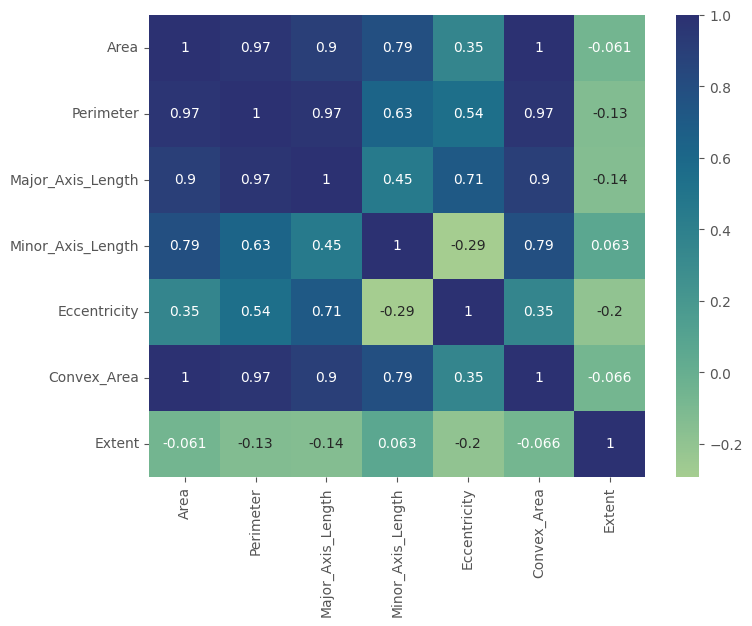

In [ ]:
matriz_corr = X.corr(numeric_only=True)
sns.heatmap(matriz_corr,annot=True,cmap="crest")

Para visualizar como os atributos do banco de dados estão relacionados decide-se plotar o mapa de calor da matriz de correlação.

##### Geração do boxplot para todos os atributos.

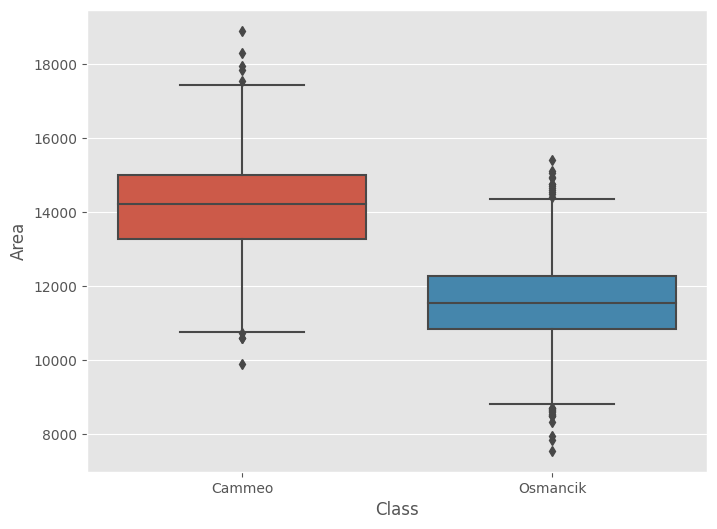

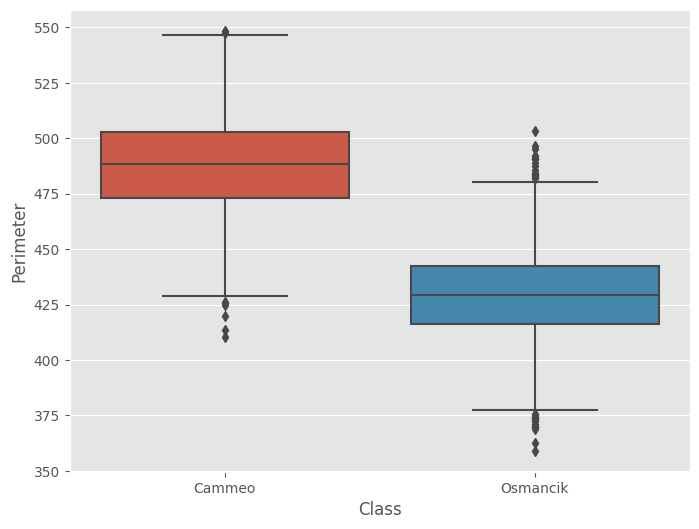

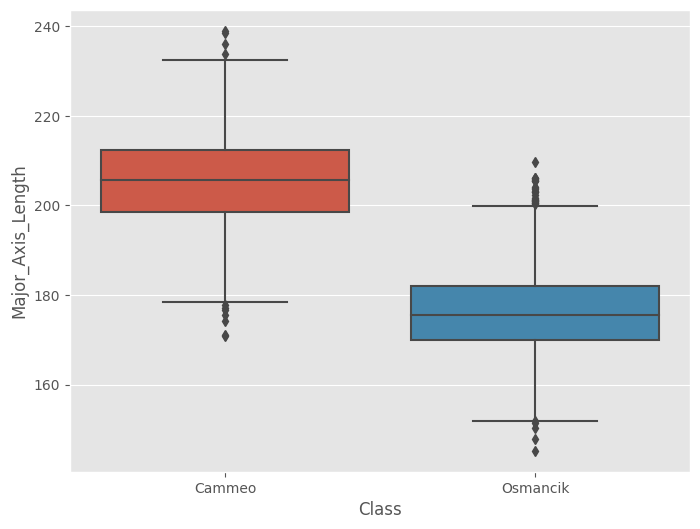

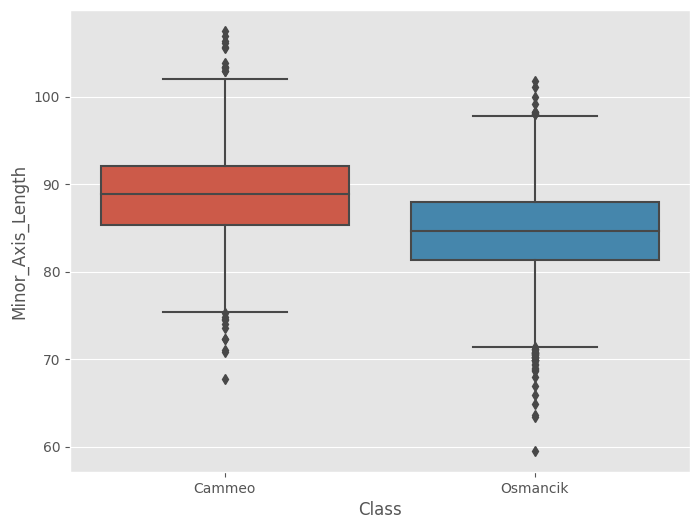

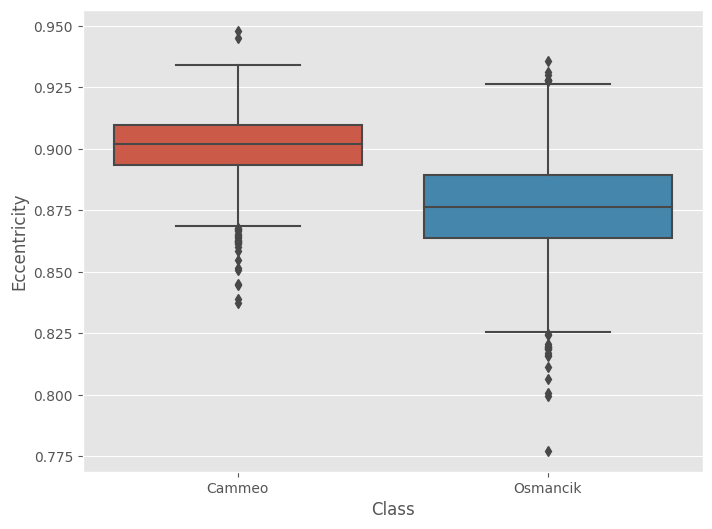

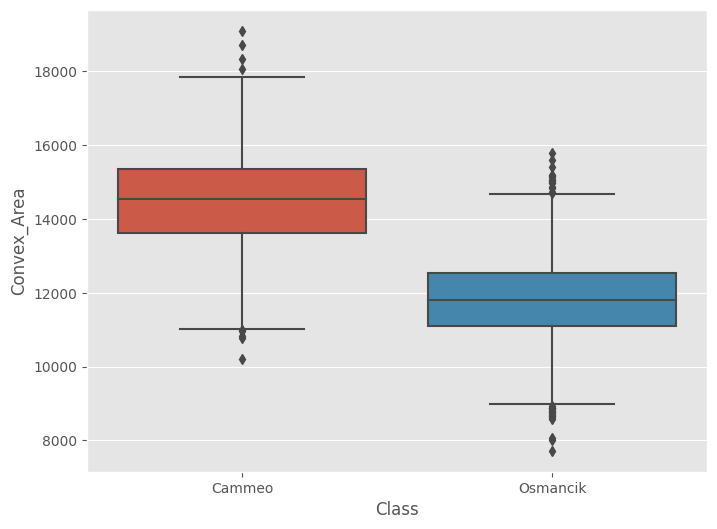

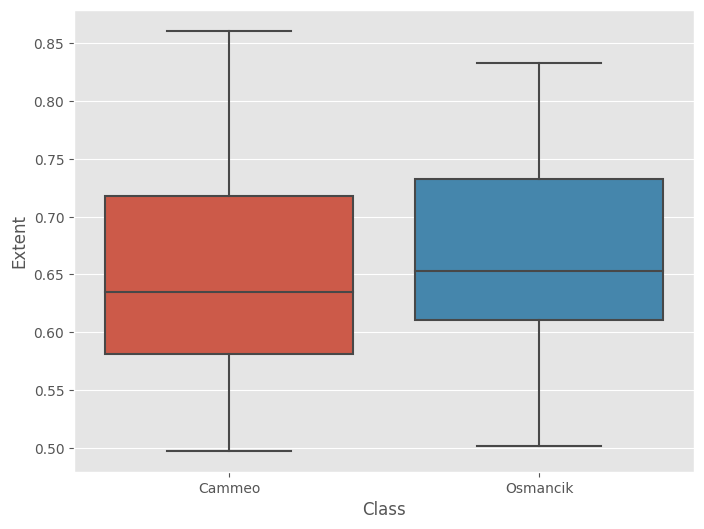

In [ ]:
for coluna in X:
    plt.figure()
    sns.boxplot(data=df, y=coluna,x=df.Class)



O que é mais evidente na análise dos bloxplots são as diferenças entre as espécies, no primeiro quartil, segundo quartil(mediana) e terceiro quartil. Como visto principalmente para os atributos: Área, perímetro, comprimento do eixo maior e menor, excentricidade e área convexa.

Também nota-se a presença de outliers em todos atributos, exceto "extensão".

Devido à diferença de escala entre os atributos utiliza-se a normalização min-max no conjunto de dados.

In [ ]:
scaler = MinMaxScaler(feature_range = (0,1))
X_norm = scaler.fit_transform(X,y)

Em relação ao atributo alvo, é necessário aplicar uma conversão simbólico-numérico nos dados para trabalhar com o classificador MLP.

In [ ]:
label_encoder = LabelEncoder()
y_numerico = label_encoder.fit_transform(y)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Separação do banco de dados nos conjuntos de teste e treinamento.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_numerico,test_size= 0.3,random_state=2)

Distribuição dos dados:

In [ ]:
print("Quantidade de dados de treino: ", len(X_train))
print("Quantidade de dados de teste: ", len(X_test))

print("Quantidade de dados de treino e atributos: ", X_train.shape)
print("Quantidade de dados de teste e atributos: ", X_test.shape)

print("Quantidade de saídas de treino e colunas: ", y_train.shape)
print("Quantidade de saídas de teste e colunas: ", y_test.shape)


Quantidade de dados de treino:  2667
Quantidade de dados de teste:  1143
Quantidade de dados de treino e atributos:  (2667, 7)
Quantidade de dados de teste e atributos:  (1143, 7)
Quantidade de saídas de treino e colunas:  (2667,)
Quantidade de saídas de teste e colunas:  (1143,)


#### Inicialização do modelo MLP.

In [ ]:
mlp_clf = MLPClassifier(random_state=2, max_iter=300).fit(X_train, y_train)

O modelo utilizado consiste num classificador Multilayer Perceptron(MLP) de duas camadas: uma oculta e uma de saída.
A função GridSearchCV do scikit-learn é utilizada para escolher o número de neurônios na camada oculta que resulta na melhor acucária entre as seguintes opções:

Camada oculta com 50, 60, 75, 90 ou 100 neurônios.


In [ ]:
param_grid = {
    'hidden_layer_sizes': [(50,),(60,),(75,),(90,),(100,)]
}

grid_search = GridSearchCV(mlp_clf, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Número de neurônios que resulta na maior acucária:", grid_search.best_params_)
print("Acucária máxima:",grid_search.best_score_ )

Número de neurônios que resulta na maior acucária: {'hidden_layer_sizes': (60,)}
Acucária máxima: 0.9309960293993409


In [ ]:
print(grid_search.cv_results_['mean_test_score'])

[0.93062009 0.93099603 0.92799273 0.92611726 0.93099603]


A acurácia máxima alcançada foi com uma camada oculta de 60 neurônios. Portanto, o MLP empregado adotará esse valor como hiperparâmetro.

In [ ]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(60,),random_state=2, max_iter=300).fit(X_train, y_train)

In [ ]:
mlp_clf.fit(X_train,y_train)

MLPClassifier(hidden_layer_sizes=(60,), max_iter=300, random_state=2)

#### Avaliação da perfomance do modelo.

A primeira avaliação do modelo realizada é a validação cruzada k-fold com a divisão em 10 subconjuntos.

In [ ]:
score_val_cruzada_mlp = cross_val_score(mlp_clf, X_train, y_train, cv=10)

In [ ]:
np.mean(score_val_cruzada_mlp)

0.9309960293993409

A acurácia média obtida para o modelo com a validação cruzada 10-fold é de 93%.

Para realizar comparações de perfomance, utiliza-se o Classificador Dummy no conjunto de dados, a fim de estabelecer uma referência inicial para o desempenho.

In [ ]:
dummy_clf = DummyClassifier(random_state=2)

In [ ]:
dummy_clf.fit(X_train,y_train)

DummyClassifier(random_state=2)

In [ ]:
score_val_cruzada_dummy = cross_val_score(dummy_clf, X_train, y_train, cv=10)

In [ ]:
np.mean(score_val_cruzada_dummy)

0.5665554335276394

A acurácia média obtida para o modelo dummy com a validação cruzada 10-fold é de 56,66%. Portanto, o modelo Multilayer perceptron utilizado no trabalho é sigficativamente melhor que o classificador dummy.

In [ ]:
y_predict = mlp_clf.predict(X_test)

Análise do desempenho do MLP pela matriz de confusão.


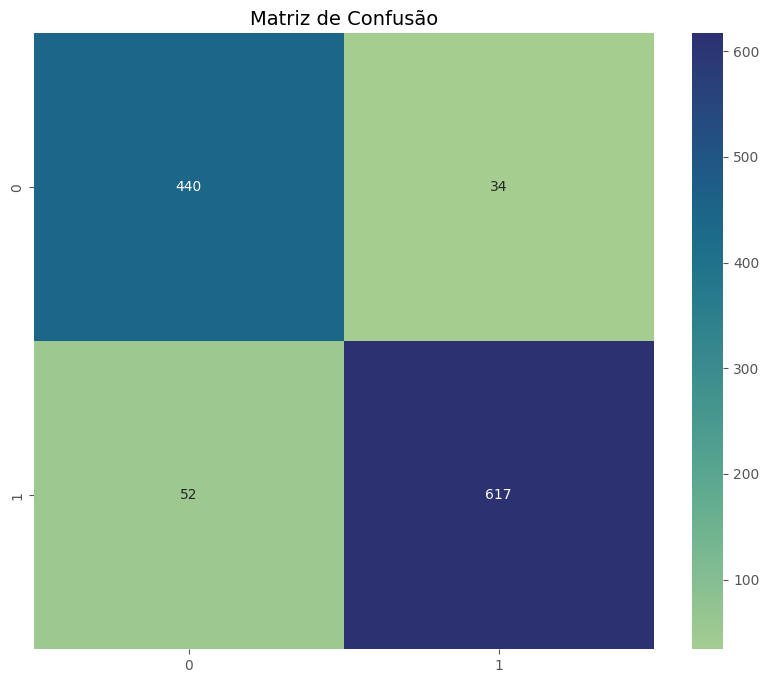

In [ ]:
fig = plt.figure(figsize=(10,8))
title = 'Matriz de Confusão'
plt.title(title, fontsize=14)

cm = confusion_matrix(y_test, y_predict)
ax = sns.heatmap(cm, annot=True, fmt='d',cmap="crest")

Pela codificação utilizada no atributo alvo:

0 - Cammeo

1 - Osmancik

Resultados obtidos com a matriz de confusão:

Número de verdadeiros negativos: 440

Número de falsos positivos: 34

Número de falsos negativos: 52

Número de verdadeiros positivos: 617

Métricas de qualidade:

In [ ]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       474
           1       0.95      0.92      0.93       669

    accuracy                           0.92      1143
   macro avg       0.92      0.93      0.92      1143
weighted avg       0.93      0.92      0.92      1143



Foi identificado uma precisão de 89% para o Cammeo e 95% para o Osmancik, o que reflete em um maior número de falsos positivos na classificação do Cammeo.

Já quanto a recall, ou taxa de verdadeiros, obtivemos 93% para Cammeo e 92% para Osmancik, mostrando que ambas espécies tem uma boa proporção de positivos reais previstos.

Sobre o f1-score, métrica que combina precisão e recall, obtemos 91% e 93%.

Já de "support", sabemos que temos 474 respostas verdadeiras para Cammeo e 669 respostas verdadeiras para Osmancik.



Conclusão: Com a análise de dados feita, principalmente após a implementação da rede MLP, a resolução do problema de classificação foi satisfatória, visto que houve uma parcela significativa de acertos na implementação da rede. Ademais, foi de grande proveito implementar os conceitos vistos em sala para um problema real.